# Proof of Concept Modeling

The purpose of this notebook is to document the process used to create the original proof of concept Tibetan-English translation model. To create this model, I drew on the Keras tutorial provided here:

https://keras.io/examples/nlp/neural_machine_translation_with_keras_nlp/

I've adapted the model from the tutorial to translate Tibetan into English, rather than English to Spanish, and streamlined the code for simplicity and computational efficiency.

In [1]:
import pathlib
import random
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import matplotlib.pyplot as plt
import pickle

TF_GPU_ALLOCATOR = 'cuda_malloc_async'


2024-07-25 21:34:04.196375: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 21:34:04.196430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 21:34:04.196481: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 21:34:04.207912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


## Setup

### Defining Some Constants

Below I defined some important constants for the model. These constants were chosen relatively arbitrarily. Most constants have been set pretty conservatively to ensure this notebook can be run even without GPU access.

In [2]:
BATCH_SIZE = 128
EPOCHS = 1000
MAX_SEQUENCE_LENGTH = 45
VOCAB_SIZE = 15000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

AUTOTUNE = tf.data.AUTOTUNE

### Working With Sentence Pairs

I've split the sentence pairs into two sets and set every English letter to be lowercase to avoid any confusion in the model. This is not necessary for Tibetan because the script does not use upper and lower cases.

In [23]:
import csv

with open('/home/j/Documents/Projects/MLotsawa/data/100k-sample.csv', newline='') as file:
    reader = csv.reader(file)
    text_pairs = list(map(tuple, reader))

text_pairs = text_pairs[1:] # drop headers
text_pairs[0]

('tsnja dn gyi gongp sang dz dol',
 'the secret treasury of realizing the intended meaning is unlocked')

In [24]:
random.shuffle(text_pairs)
num_val_samples = int(0.05 * len(text_pairs))
num_train_samples = len(text_pairs) - num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")

100000 total pairs
95000 training pairs
5000 validation pairs


## Creating the Tokenizer

The tokenizer will assign each unique word in the dataset a 'token' a unique number that allows the data to be treated numerically during model training. In order to do this, a "vocabulary" must first be created. This is a complete list of the unique English and Tibetan words in the dataset.

### Vocabulary

In [25]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )

    return vocab

### Tokenizing

Note that I've set aside some peculiar tokens. These correspond to whitespace,unknown characters, the beginnings and endings of sentences. I don't want the tokenizer to treat these things as words that need to be tokenized.

In [26]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

tib_samples = [text_pair[0] for text_pair in train_pairs]
tib_vocab = train_word_piece(tib_samples, VOCAB_SIZE, reserved_tokens)

eng_samples = [text_pair[1] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, VOCAB_SIZE, reserved_tokens)

Here I have tokenized the vocabularies.

In [27]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)

tib_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=tib_vocab, lowercase=False
)

Tokenizers can be saved like so.

In [28]:
with open('/home/j/Documents/Projects/MLotsawa/models/keras/tokenizers/eng-tokenizer.pickle', 'wb') as handle:
    pickle.dump(eng_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/home/j/Documents/Projects/MLotsawa/models/keras/tokenizers/tib-tokenizer.pickle', 'wb') as handle:
    pickle.dump(tib_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

The tokenizers can be reopened with the following code.

In [1]:
""" with open('/tokenizers/tib-tokenizer.pickle', 'rb') as handle:
    tib_tokenizer = pickle.load(handle)

with open('/tokenizers/eng-tokenizer.pickle', 'rb') as handle:
    eng_tokenizer = pickle.load(handle) """

" with open('/tokenizers/tib-tokenizer.pickle', 'rb') as handle:\n    tib_tokenizer = pickle.load(handle)\n\nwith open('/tokenizers/eng-tokenizer.pickle', 'rb') as handle:\n    eng_tokenizer = pickle.load(handle) "

### Data Preprocessing

Next, I preprocessed each batch of data. This consisted of re-assembling the English-Tibetan sentence pairs. Each sentence must be padded with the "[PAD]" whitespace token in order to make each sequence of tokens the same length. This is because the model expects inputs of a particular shape. Once the sentence has been padded to the appropriate length, a [START] token can be appended to the beginning and an [END] token appended to the end.

Finally, this assembled dataset is split into training and validation sets.

In [29]:
def tib_eng_preprocess_batch(tib, eng):

    tib = tib_tokenizer(tib)
    eng = eng_tokenizer(eng)
    

    # add special tokens [start] and [end] and pad tib
    tib_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length = MAX_SEQUENCE_LENGTH,
        start_value = tib_tokenizer.token_to_id("[START]"),
        end_value = tib_tokenizer.token_to_id("[END]"),
        pad_value = tib_tokenizer.token_to_id("[PAD]")
    )

    tib = tib_start_end_packer(tib)

    # pad eng to max_sequence_length
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH+1,
        pad_value = eng_tokenizer.token_to_id("[PAD]"),
    )

    eng = eng_start_end_packer(eng)



    return (
        {
        "encoder_inputs": tib,
        "decoder_inputs": eng[:, :-1]
        },
        eng[:, 1:],
    )

def make_dataset(pairs, batch_size=BATCH_SIZE):
    tib_texts, eng_texts = zip(*pairs)
    tib_texts = list(tib_texts)
    eng_texts = list(eng_texts)
    dataset = tf.data.Dataset.from_tensor_slices((tib_texts, eng_texts))
    dataset=dataset.batch(batch_size)
    dataset = dataset.map(tib_eng_preprocess_batch, num_parallel_calls=AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

tib_eng_train_ds = make_dataset(train_pairs)
tib_eng_val_ds = make_dataset(val_pairs)

### Creating the Model

This model is an Autoencoder, which consists of an encoder and a decoder. 

The encoder input layer takes in a set of tokenized inputs. These inputs are then passed to a layer that accounts for the number assigned to the token as well as the position of that token in the sentence. The next layer is a dense Encoder layer.

The decoder takes in a set of tokenized inputs from the Tibetan dataset and passes them to a layer that will account for the token number and position of the token in those sentences. This is then passed to a dense Decoder layer.

Both the Encoder and Decoder layers are helpfully provided out-of-the-box by Keras.

In [30]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length = MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim = INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

tib_eng_translator = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="tib_eng_translator",
) 

# can also be open from a saved version like so
# tib_eng_translator = tf.keras.models.load_model("path-to-model")

### Model Summary

In [31]:
tib_eng_translator.summary()

Model: "tib_eng_translator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 256)            3851520   ['encoder_inputs[0][0]']      
 ng_2 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []           

## Compilation

Here I've compiled the model.

Of note here is the choice of optimization algorith. I have used RMSProp. RMSProp is similar to Adagrad, and it converges much more quickly than, say, SGD. However, it is less susceptible to vanishing gradients. This is perfect for our small dataset with small batch sizes.

The loss function is Sparse Categorical Crossentropy. Not every word appears in every sentence so the data for most natural language related tasks is necessarily sparse.

In [50]:
val_loss_callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [51]:
tib_eng_translator.compile(
    "rmsprop", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"],
)

## Fitting the Model

In [52]:
tib_eng_history = tib_eng_translator.fit(
    tib_eng_train_ds, 
    epochs=EPOCHS, 
    validation_data=tib_eng_val_ds,
    callbacks=[val_loss_callback]
    )

Epoch 1/1000


743/743 [==============================] - 62s 74ms/step - loss: 5.2157 - accuracy: 0.2460 - val_loss: 4.2856 - val_accuracy: 0.3189
Epoch 2/1000
743/743 [==============================] - 40s 54ms/step - loss: 4.0783 - accuracy: 0.3422 - val_loss: 3.6052 - val_accuracy: 0.3945
Epoch 3/1000
743/743 [==============================] - 41s 55ms/step - loss: 3.4485 - accuracy: 0.4168 - val_loss: 3.0937 - val_accuracy: 0.4683
Epoch 4/1000
743/743 [==============================] - 40s 54ms/step - loss: 3.0015 - accuracy: 0.4817 - val_loss: 2.8205 - val_accuracy: 0.5237
Epoch 5/1000
743/743 [==============================] - 40s 54ms/step - loss: 2.6582 - accuracy: 0.5375 - val_loss: 2.6511 - val_accuracy: 0.5601
Epoch 6/1000
743/743 [==============================] - 40s 54ms/step - loss: 2.3983 - accuracy: 0.5825 - val_loss: 2.4899 - val_accuracy: 0.5871
Epoch 7/1000
743/743 [==============================] - 39s 53ms/step - loss: 2.2017 - accuracy: 0.6165 - val_loss: 2.3492 - val_accuracy

In [53]:
tib_eng_translator.save('tib-eng-translator.keras')

## Results

The results of model training with respect to loss can be viewed below.

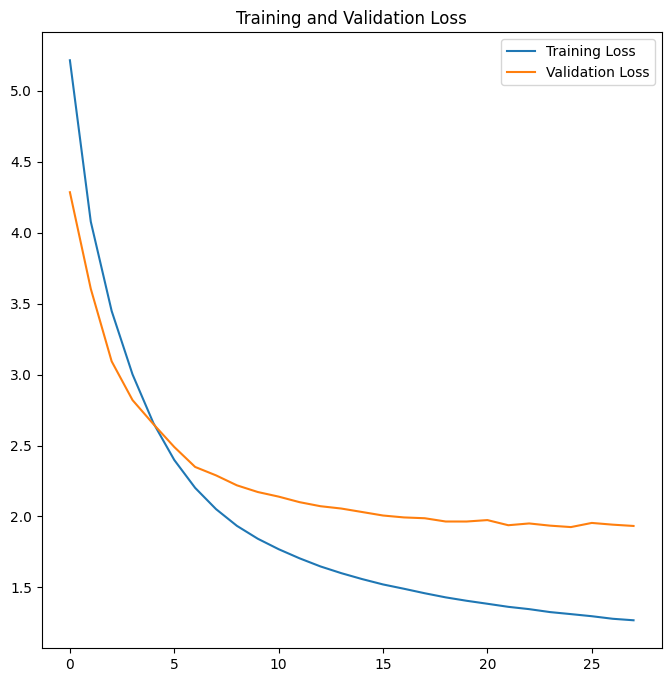

In [54]:
loss = tib_eng_history.history['loss']
val_loss = tib_eng_history.history['val_loss']

epochs_range = range(len(tib_eng_history.history['loss']))

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()